## Содержание
* [Введение](#Введение )
* [Анализ данных](#exploratory-analysis)
* [Визуальный анализ](#визуальный-анализ-изображений)
* [Подготовка данных](#подготовка-данных-для-обучения)
* [Обучение модели и анализ результатов](#обучение-модели-и-анализ-результатов)
* [Улучшение модели](#улучшение-модели)
    * [Обновление функций](#изменяем-функции-для-предобработки-данных)
    * [Fine-tune](#используем-предобученную-модель-efficientnetv2s-для-обучения)
    * [Сравнение с baseline моделью](#сравнение-с-baseline-моделью)
    * [Выводы](#выводы)
    * [TODO](#todo)

# Введение

В данном ноутбуке представлен анализ датасета NIH Chest X-rays.

Цель данной работы включает:
- Проведение разведочного анализа данных (EDA) для понимания структуры датасета, распределения классов и основных характеристик изображений
- Построение baseline модели для классификации патологий на рентгеновских снимках, которая послужит отправной точкой для дальнейшего улучшения

# Exploratory Analysis

### Импортируем необходимые модули

In [1]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import tensorflow
import os
# Отключить oneDNN info
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

# Уровень логирования TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Только errors

os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=2'

# Отключить warnings PIL/PNG
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', message='.*iCCP.*')

# НАСТРОЙКИ ПАМЯТИ
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tensorflow.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU доступно: {len(gpus)}")
    except RuntimeError as e:
        print(e)

from keras.src.utils.module_utils import tensorflow

warnings.filterwarnings('ignore')

2025-12-08 11:21:40.537370: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-08 11:21:41.355035: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-08 11:21:43.442930: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


GPU доступно: 1


### Загрузка данных
Базовая информация находится в файле Data_entry_2017, давайте прочитаем его и посмотрим что в нем есть

In [2]:
data_entry_df = pd.read_csv('data/Data_Entry_2017.csv')
data_entry_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


Файл обладает следующей структурой:
1. Image index: *Названия файла с изображением*
2. Finding Labels: *Диагнозы — может быть один диагноз, несколько через |, или No Finding* <- **Это наш таргет**
3. Follow-up: *Номер повторного визита пациента*
4. Patient ID: *ID пациента, которому принадлежит снимок и остальные признаки, обратите внимание у одного пациента может быть несколько снимков*
5. Patient Age: *Возраст пациента*
6. Patient Gender: *Биологический пол пациента*
7. View Position: *Позиция съёмки (например, PA — posterior-anterior, AP — anterior-posterior)*
8. OriginalImage[Width: *Ширина оригинального изображения в пикселях*
9. Height]: *Высота оригинального изображения в пикселях*
10. OriginalImagePixelSpacing[x: *Расстояние между пикселями по горизонтали (мм)*
11. y]: *Расстояние между пикселями по вертикали (мм)*
12. Unnamed: 11: Пустая колонка(кажется является мусором)

Проверяем данные на наличие пропущенных значений

In [3]:
data_entry_df.isnull().sum()

Image Index                         0
Finding Labels                      0
Follow-up #                         0
Patient ID                          0
Patient Age                         0
Patient Gender                      0
View Position                       0
OriginalImage[Width                 0
Height]                             0
OriginalImagePixelSpacing[x         0
y]                                  0
Unnamed: 11                    112120
dtype: int64

Как мы видим в датасете нет пустых значений, за исключением мусорного поля.
Давайте удалим его

In [4]:
data_entry_df = data_entry_df.drop(columns=['Unnamed: 11'])

Распределение данных по таргету

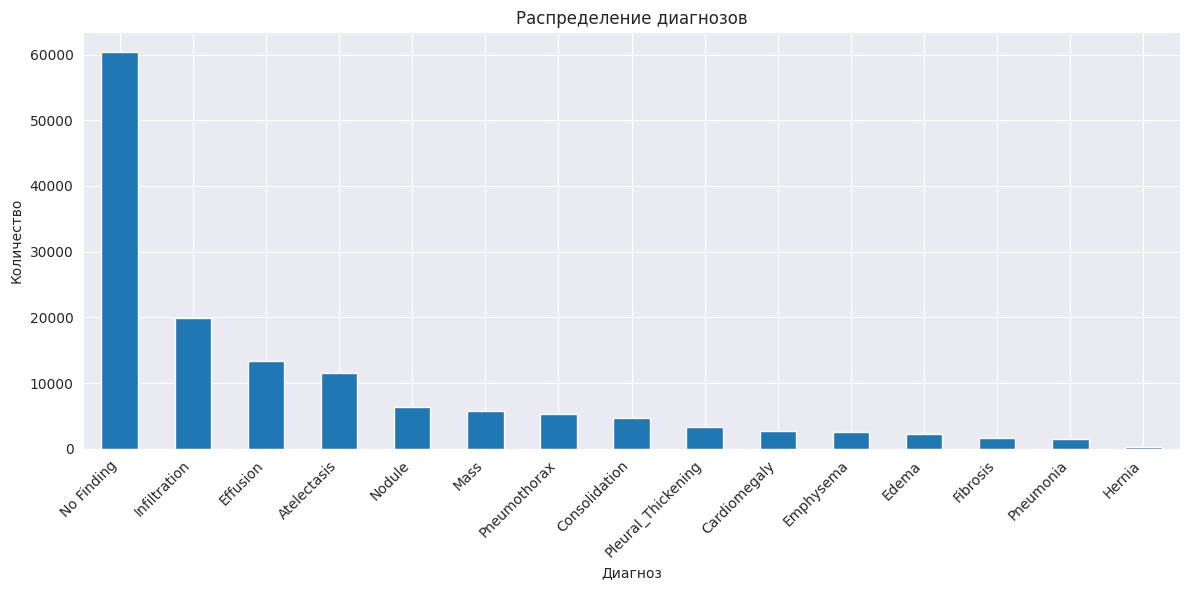

In [5]:
all_labels = data_entry_df['Finding Labels'].str.split('|').explode()
label_counts = all_labels.value_counts()

plt.figure(figsize=(12, 6))
label_counts.plot(kind='bar')
plt.title('Распределение диагнозов')
plt.xlabel('Диагноз')
plt.ylabel('Количество')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

1. Распределения снимков с болезнью к снимкам без болезни приблизительно 50% это хорошо
2. Распределение распознанных болезней очень плохое, если мы будем сравнивать "каждый с каждым", то увидим большие перекосы в данных

Распределение возраста пациентов

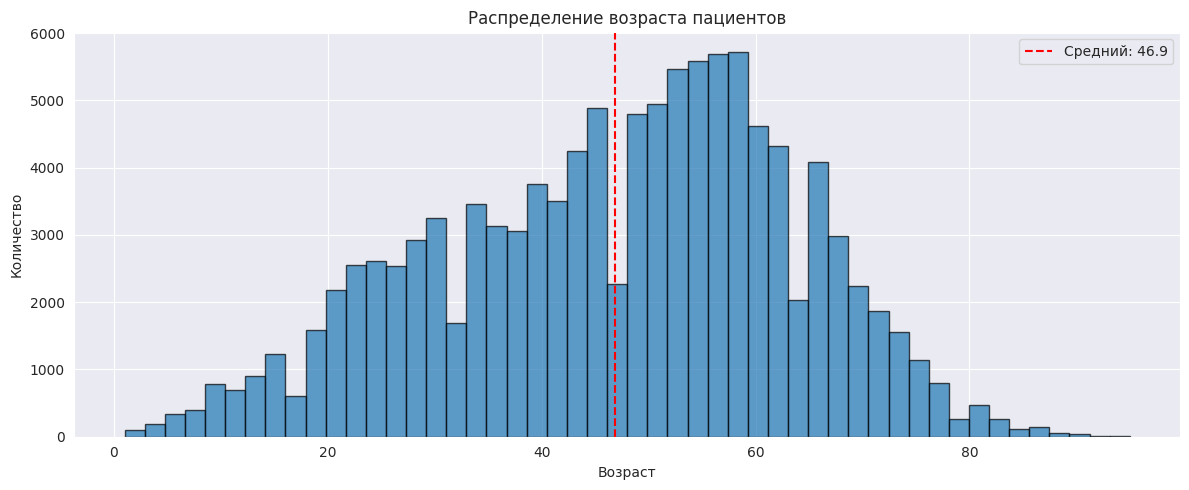

In [6]:
df_clean = data_entry_df[data_entry_df['Patient Age'] <= 100]

plt.figure(figsize=(12, 5))
plt.hist(df_clean['Patient Age'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Распределение возраста пациентов')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.axvline(df_clean['Patient Age'].mean(), color='red', linestyle='--', label=f'Средний: {df_clean["Patient Age"].mean():.1f}')
plt.legend()
plt.tight_layout()
plt.show()

Возраст по полу

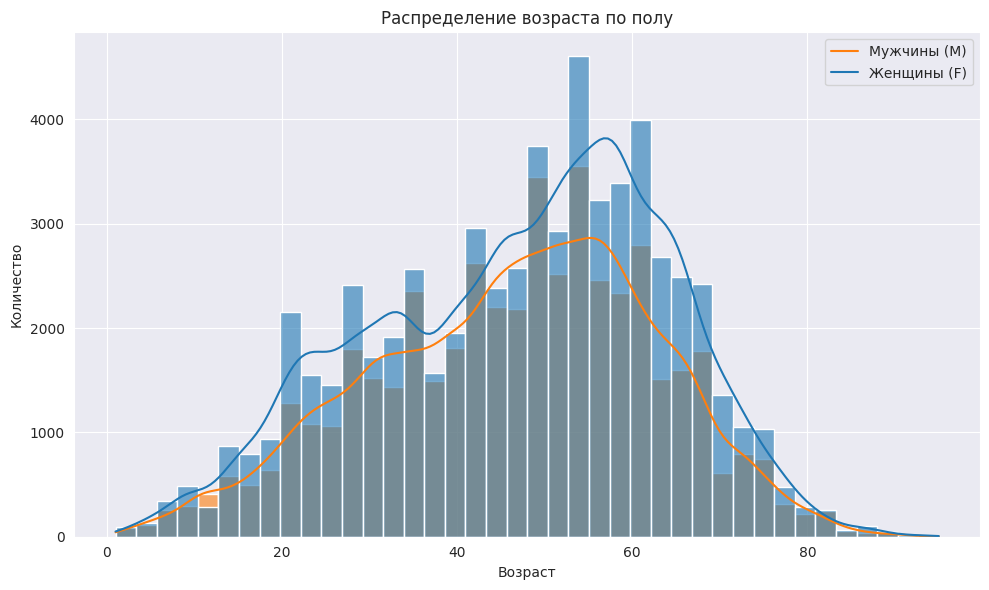

In [9]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_clean, x='Patient Age', hue='Patient Gender',
             bins=40, alpha=0.6, kde=True)
plt.title('Распределение возраста по полу')
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.legend(['Мужчины (M)', 'Женщины (F)'])
plt.tight_layout()
plt.show()

Средний возраст по диагнозам

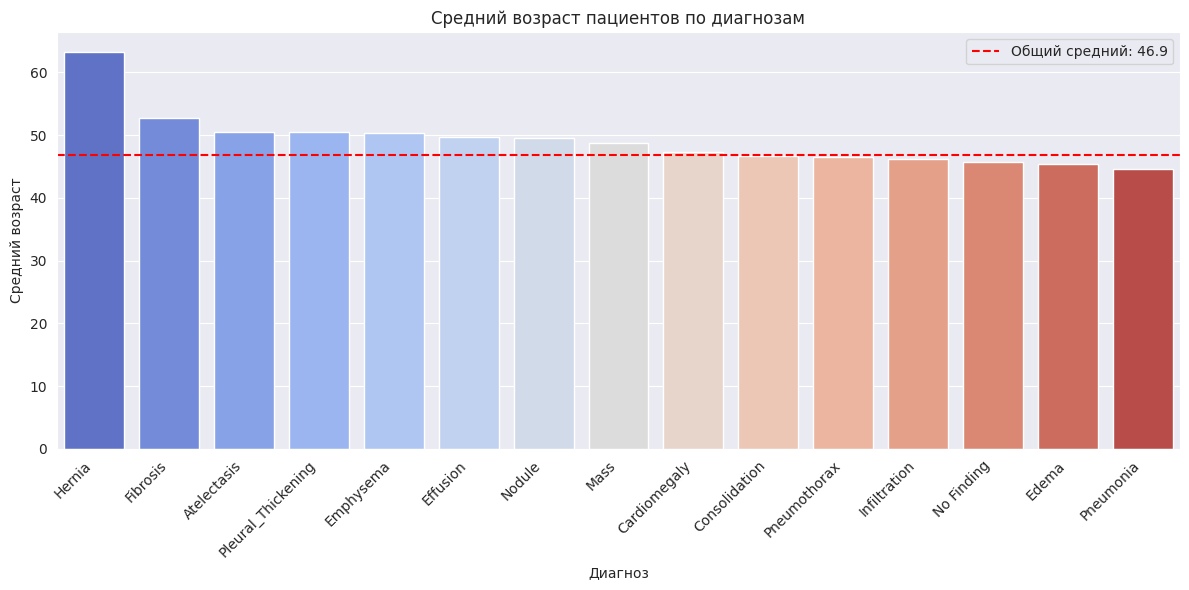

In [7]:
labels = ['No Finding', 'Atelectasis', 'Cardiomegaly', 'Effusion',
          'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax',
          'Consolidation', 'Edema', 'Emphysema', 'Fibrosis',
          'Pleural_Thickening', 'Hernia']

for label in labels:
    df_clean[label] = df_clean['Finding Labels'].str.contains(label).astype(int)

# Считаем средний возраст для каждого диагноза
mean_ages = {}
for label in labels:
    mean_ages[label] = df_clean[df_clean[label] == 1]['Patient Age'].mean()

mean_ages = pd.Series(mean_ages).sort_values(ascending=False)

# График
plt.figure(figsize=(12, 6))
ax = sns.barplot(x=mean_ages.index, y=mean_ages.values, palette='coolwarm')
plt.axhline(df_clean['Patient Age'].mean(), color='red', linestyle='--',
            label=f'Общий средний: {df_clean["Patient Age"].mean():.1f}')
plt.title('Средний возраст пациентов по диагнозам')
plt.xlabel('Диагноз')
plt.ylabel('Средний возраст')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

"Возрастные" болезни (выше среднего 46.9 лет):
1. Hernia (~63 года) — самый высокий средний возраст
2. Fibrosis (~53 года) — хронические изменения
3. Atelectasis (~51 год)
4. Pleural_Thickening (~51 год)
5. Emphysema (~50 лет) — связана с курением/возрастом

"Молодые" болезни (ниже среднего):
1. Pneumonia (~44 года) — острое заболевание
2. Edema (~44 года)
3. No Finding (~45 лет) — здоровые пациенты моложе

Клинические инсайты:
Hernia резко выделяется — это логично, так как грыжи часто развиваются с возрастом из-за ослабления тканей
Fibrosis и Emphysema — хронические дегенеративные процессы, накапливающиеся годами
Pneumonia поражает все возрасты довольно равномерно (близко к общему среднему)

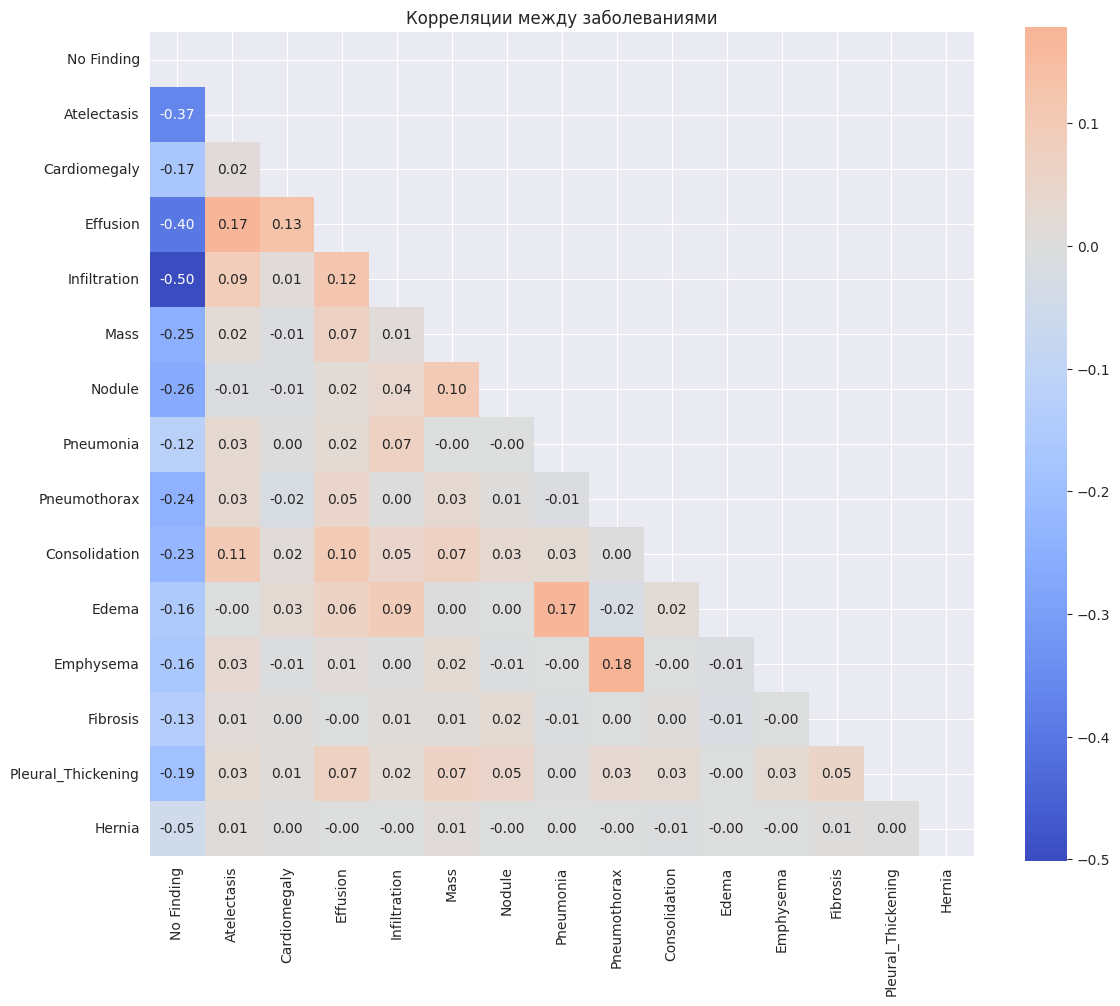

Топ-10 парных корреляций:
Pneumothorax ↔ Emphysema: 0.178
Pneumonia ↔ Edema: 0.174
Atelectasis ↔ Effusion: 0.172
Cardiomegaly ↔ Effusion: 0.130
Effusion ↔ Infiltration: 0.118
Atelectasis ↔ Consolidation: 0.109
Mass ↔ Nodule: 0.101
Effusion ↔ Consolidation: 0.101
Infiltration ↔ Edema: 0.094
Atelectasis ↔ Infiltration: 0.093


In [8]:
correlation_matrix = df_clean[labels].corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', center=0, square=True)
plt.title('Корреляции между заболеваниями')
plt.tight_layout()
plt.show()

# Самые сильные положительные корреляции
corr_pairs = []
for i in range(len(labels)):
    for j in range(i+1, len(labels)):
        corr_pairs.append((labels[i], labels[j], correlation_matrix.iloc[i,j]))

corr_pairs.sort(key=lambda x: x[2], reverse=True)
print("Топ-10 парных корреляций:")
for pair in corr_pairs[:10]:
    print(f"{pair[0]} ↔ {pair[1]}: {pair[2]:.3f}")

Как мы видим заболевания могут быть связанны, но в целом связь не сильная(максимум 17.8%)

# Визуальный анализ изображений

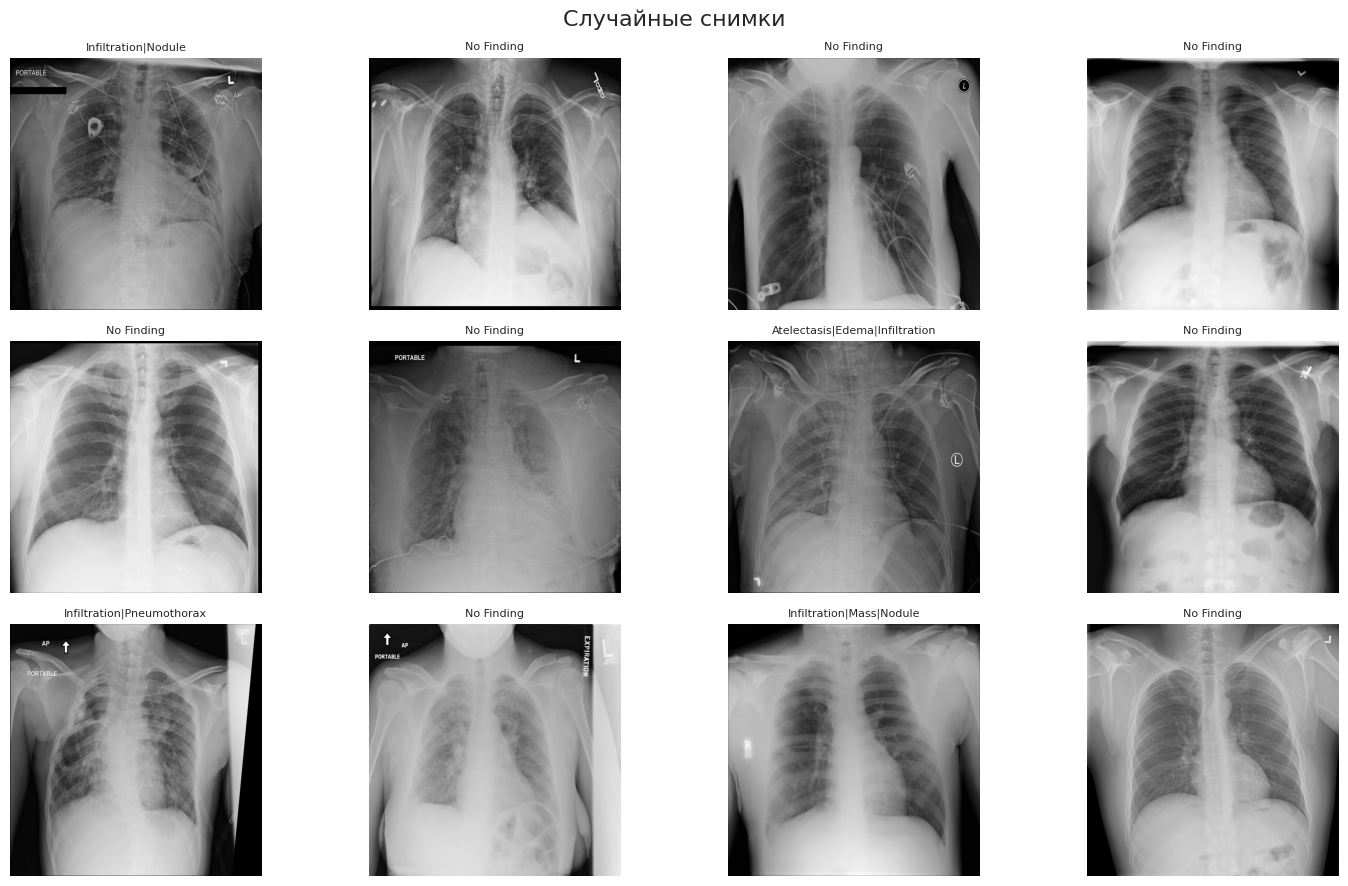

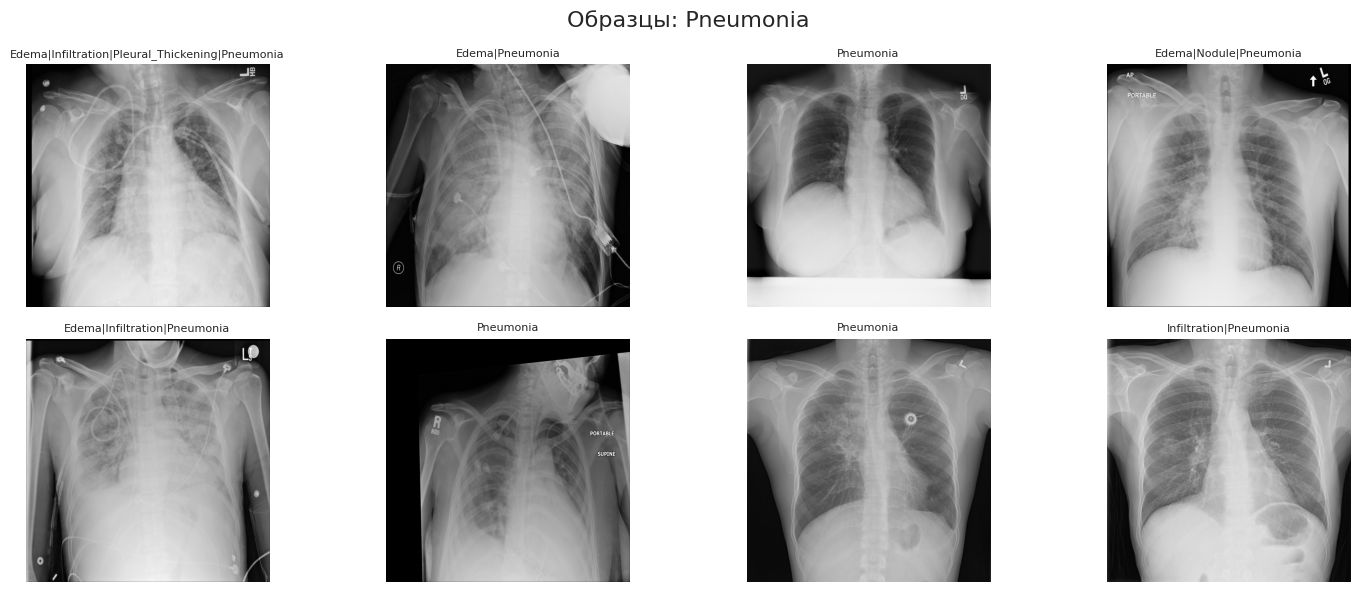

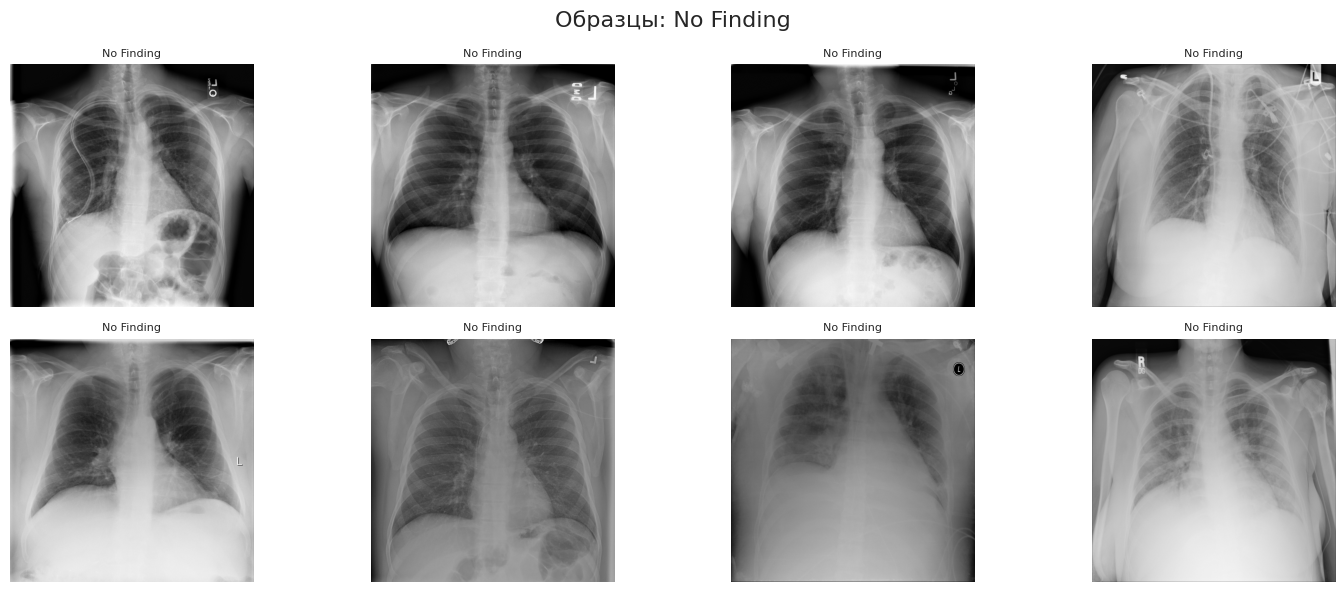

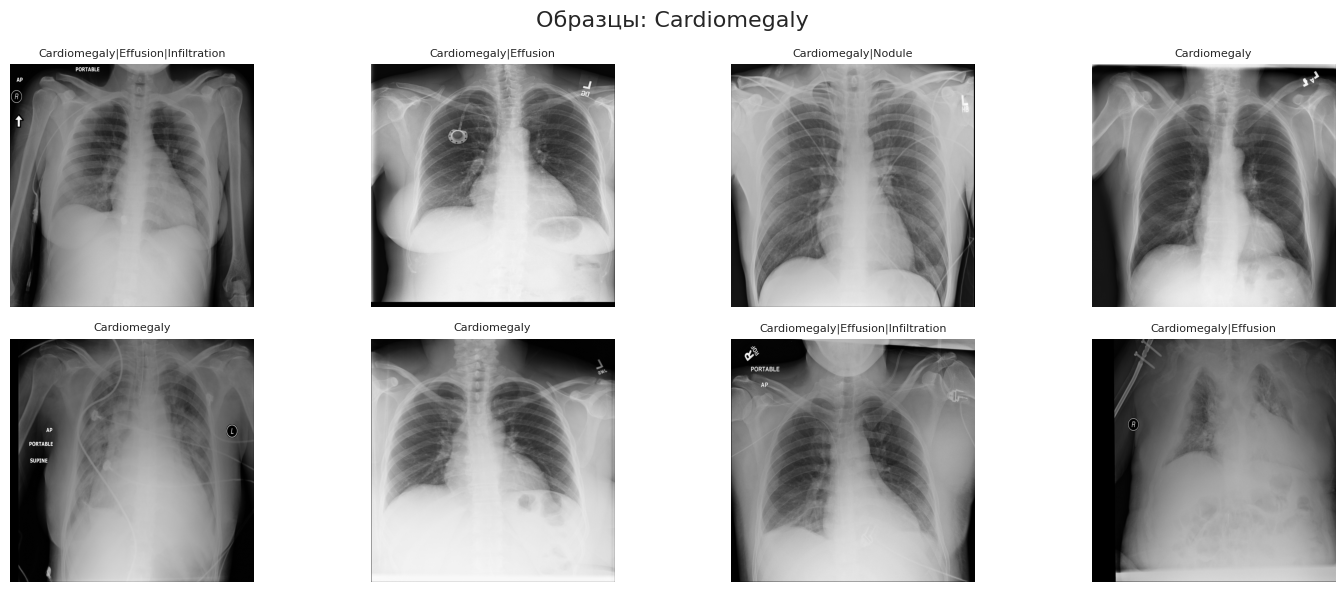

In [12]:
import os


def find_image_path(image_name, base_dir):
    """Находим изображение в любой из папок images_xxx"""
    for folder in os.listdir(base_dir):
        if folder.startswith('images_'):
            img_path = os.path.join(base_dir, folder, 'images', image_name)
            if os.path.exists(img_path):
                return img_path
    return None

def load_sample_images(df, base_dir, n_samples=12):
    """Загружаем случайные изображения с правильным путем"""
    sample_df = df.sample(n_samples)
    images = []
    labels = []


    for _, row in sample_df.iterrows():
        img_path = find_image_path(row['Image Index'], base_dir)

        if img_path:
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    images.append(img)
                    labels.append(row['Finding Labels'][:50])
                else:
                    print(f"✗ Не удалось загрузить: {img_path}")
            except Exception as e:
                print(f"✗ Ошибка при загрузке {img_path}: {e}")
        else:
            print(f"✗ Не найдено: {row['Image Index']}")

    return images, labels

def plot_image_grid(images, labels, title="Образцы изображений"):
    """Создаем сетку изображений с проверкой на пустой список"""
    if len(images) == 0:
        print("❌ Нет изображений для отображения!")
        return

    n_images = len(images)
    cols = 4
    rows = max(1, (n_images + cols - 1) // cols)  # Минимум 1 строка

    fig, axes = plt.subplots(rows, cols, figsize=(15, rows*3))

    if rows == 1:
        axes = axes if cols > 1 else [axes]
    else:
        axes = axes.flatten()

    for i in range(n_images):
        axes[i].imshow(images[i], cmap='gray')
        axes[i].set_title(labels[i], fontsize=8)
        axes[i].axis('off')

    for i in range(n_images, len(axes)):
        axes[i].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()

images, labels = load_sample_images(df_clean, 'data')
plot_image_grid(images, labels, "Случайные снимки")

for diagnosis in ['Pneumonia', 'No Finding', 'Cardiomegaly']:
    diagnosis_df = df_clean[df_clean['Finding Labels'].str.contains(diagnosis)]
    images, labels = load_sample_images(diagnosis_df, 'data', 8)
    plot_image_grid(images, labels, f"Образцы: {diagnosis}")

Цветовой анализ

Начинаем анализ 1000 изображений...
Обработано: 0/1000
Обработано: 100/1000
Обработано: 200/1000
Обработано: 300/1000
Обработано: 400/1000
Обработано: 500/1000
Обработано: 600/1000
Обработано: 700/1000
Обработано: 800/1000
Обработано: 900/1000

Результат анализа:
Успешно обработано: 1000
Не найдено: 0
Общий процент успеха: 100.0%
✅ Данные получены: 1000 изображений


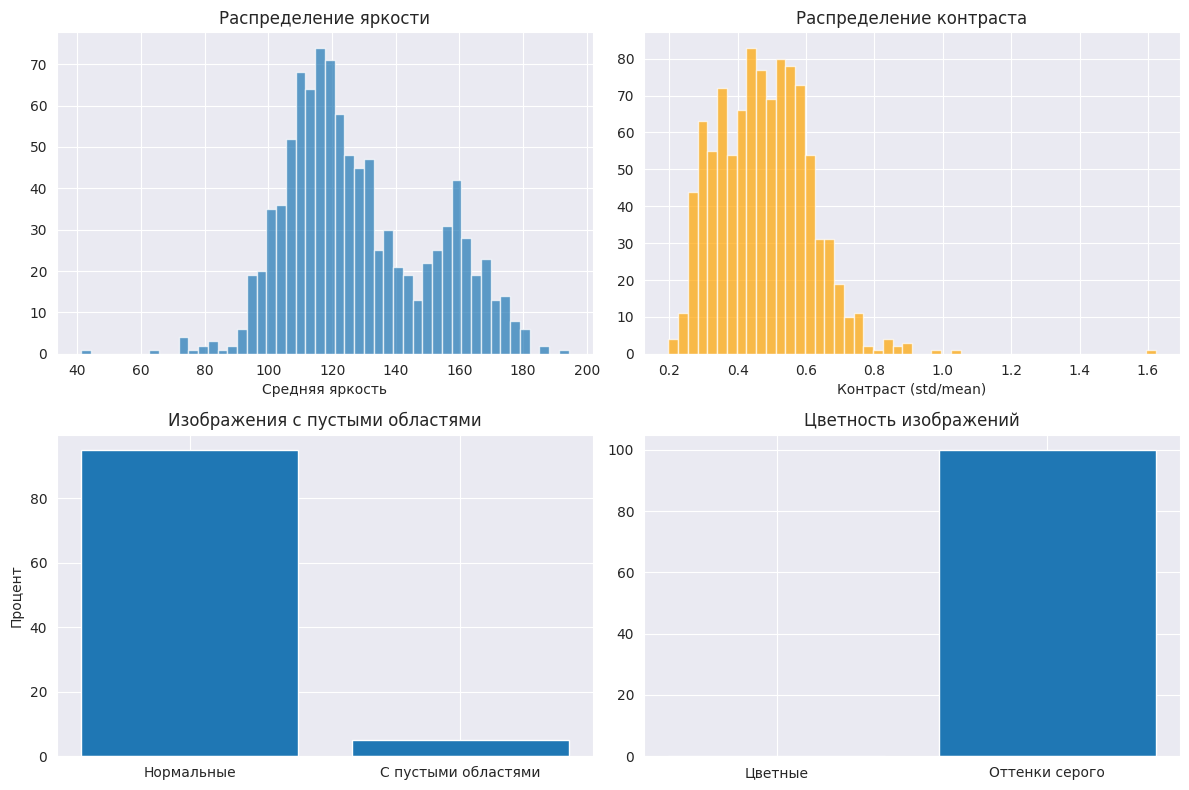

Средняя яркость: 128.2
Изображений с пустыми областями: 5.1%
Оттенков серого: 100.0%


In [9]:
def find_image_path(image_name, base_dir):
    """Находим изображение в любой из папок images_xxx"""
    for folder in os.listdir(base_dir):
        if folder.startswith('images_'):
            img_path = os.path.join(base_dir, folder, 'images', image_name)
            if os.path.exists(img_path):
                return img_path
    return None

def analyze_image_properties(df, base_dir, n_samples=1000):
    """Анализ свойств изображений"""
    sample_df = df.sample(n_samples)

    properties = {
        'mean_brightness': [],
        'std_brightness': [],
        'is_grayscale': [],
        'has_empty_regions': [],
        'contrast': []
    }

    processed_count = 0
    not_found_count = 0

    print(f"Начинаем анализ {n_samples} изображений...")

    for i, (_, row) in enumerate(sample_df.iterrows()):
        if i % 100 == 0:  # Прогресс каждые 100 изображений
            print(f"Обработано: {i}/{n_samples}")

        img_path = find_image_path(row['Image Index'], base_dir)

        if img_path and os.path.exists(img_path):
            try:
                # Загружаем в цвете для проверки
                img_color = cv2.imread(img_path)
                img_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                if img_color is not None and img_gray is not None:
                    # Проверяем на оттенки серого
                    # Более надежный способ проверки
                    b, g, r = cv2.split(img_color)
                    is_grayscale = np.array_equal(b, g) and np.array_equal(g, r)

                    # Основные метрики
                    mean_val = np.mean(img_gray)
                    std_val = np.std(img_gray)

                    properties['mean_brightness'].append(mean_val)
                    properties['std_brightness'].append(std_val)
                    properties['is_grayscale'].append(is_grayscale)
                    properties['has_empty_regions'].append(np.sum(img_gray == 0) > img_gray.size * 0.1)
                    properties['contrast'].append(std_val / mean_val if mean_val > 0 else 0)

                    processed_count += 1
                else:
                    print(f"Не удалось загрузить: {img_path}")

            except Exception as e:
                print(f"Ошибка при обработке {img_path}: {e}")
        else:
            not_found_count += 1
            if not_found_count <= 5:  # Показываем первые 5 не найденных
                print(f"Не найдено: {row['Image Index']}")

    print(f"\nРезультат анализа:")
    print(f"Успешно обработано: {processed_count}")
    print(f"Не найдено: {not_found_count}")
    print(f"Общий процент успеха: {processed_count/n_samples*100:.1f}%")

    return properties

# Анализируем свойства с отладкой
props = analyze_image_properties(df_clean, 'data', 1000)

# Проверяем, есть ли данные
if len(props['mean_brightness']) == 0:
    print("❌ НЕТ ДАННЫХ! Проверьте пути к изображениям.")
    print("\nПроверим структуру папок:")
    base_dir = 'data'
    for folder in os.listdir(base_dir):
        if folder.startswith('images_'):
            images_folder = os.path.join(base_dir, folder, 'images')
            if os.path.exists(images_folder):
                count = len([f for f in os.listdir(images_folder) if f.endswith('.png')])
                print(f"  {folder}/images: {count} файлов")
else:
    print(f"✅ Данные получены: {len(props['mean_brightness'])} изображений")

    # Визуализация (только если есть данные)
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))

    axes[0,0].hist(props['mean_brightness'], bins=50, alpha=0.7)
    axes[0,0].set_title('Распределение яркости')
    axes[0,0].set_xlabel('Средняя яркость')

    axes[0,1].hist(props['contrast'], bins=50, alpha=0.7, color='orange')
    axes[0,1].set_title('Распределение контраста')
    axes[0,1].set_xlabel('Контраст (std/mean)')

    # Пустые области
    empty_pct = np.mean(props['has_empty_regions']) * 100
    axes[1,0].bar(['Нормальные', 'С пустыми областями'],
                  [100-empty_pct, empty_pct])
    axes[1,0].set_title('Изображения с пустыми областями')
    axes[1,0].set_ylabel('Процент')

    # Цветность
    grayscale_pct = np.mean(props['is_grayscale']) * 100
    axes[1,1].bar(['Цветные', 'Оттенки серого'],
                  [100-grayscale_pct, grayscale_pct])
    axes[1,1].set_title('Цветность изображений')

    plt.tight_layout()
    plt.show()

    print(f"Средняя яркость: {np.mean(props['mean_brightness']):.1f}")
    print(f"Изображений с пустыми областями: {np.mean(props['has_empty_regions'])*100:.1f}%")
    print(f"Оттенков серого: {np.mean(props['is_grayscale'])*100:.1f}%")

Отличное техническое качество:

- Средняя яркость: 126.7 — оптимальная для рентген-снимков (хорошая экспозиция)
- Контраст: пик 0.4-0.5 — достаточный для различения анатомических структур
- 100% оттенки серого — корректный формат для медицинской визуализации

Минимум технических проблем:

- Только 5.7% с пустыми областями — очень низкий процент бракованных снимков
- Нормальное распределение яркости — указывает на стандартизированную съёмку

# Подготовка данных для обучения

Описываем функции которые упрощают и автоматизируют pipeline обучения

In [21]:
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers, callbacks
def load_and_prepare_data(csv_path, base_dir):
    df = pd.read_csv(csv_path)

    df_clean_for_training = df[df['Patient Age'] <= 100].copy()

    labels = [
        'No Finding', 'Atelectasis', 'Cardiomegaly', 'Effusion',
        'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax',
        'Consolidation', 'Edema', 'Emphysema', 'Fibrosis',
        'Pleural_Thickening', 'Hernia'
    ]

    # Создаем бинарные колонки для каждого диагноза
    for label in labels:
        df_clean_for_training[label] = df_clean_for_training['Finding Labels'].str.contains(label).astype(int)

    # Создаем мапинг путей к изображениям
    image_paths = create_image_mapping(base_dir)

    # Добавляем полные пути к изображениям
    df_clean_for_training['full_path'] = df_clean_for_training['Image Index'].map(image_paths)

    # Убираем записи без найденных изображений
    df_clean_for_training = df_clean_for_training.dropna(subset=['full_path'])

    print(f"Загружено записей: {len(df_clean_for_training)}")
    print(f"Найдено изображений: {len(df_clean_for_training)}")

    return df_clean_for_training, labels

def create_image_mapping(base_dir):
    """Создаем словарь путей к изображениям"""
    image_paths = {}

    for folder in os.listdir(base_dir):
        if folder.startswith('images_'):
            images_folder = os.path.join(base_dir, folder, 'images')
            if os.path.exists(images_folder):
                for img_file in os.listdir(images_folder):
                    if img_file.endswith('.png'):
                        image_paths[img_file] = os.path.join(images_folder, img_file)

    return image_paths

def create_data_splits(df, labels, test_size=0.2, val_size=0.2, random_state=42):
    """Создаем train/val/test разделения"""

    # Стратифицируем по наиболее частым диагнозам
    stratify_cols = ['No Finding', 'Atelectasis', 'Cardiomegaly', 'Effusion']
    stratify_labels = df[stratify_cols].apply(lambda x: ''.join(x.astype(str)), axis=1)

    # Train/Test split
    train_df, test_df = train_test_split(
        df,
        test_size=test_size,
        stratify=stratify_labels,
        random_state=random_state
    )

    # Train/Val split
    stratify_labels_train = train_df[stratify_cols].apply(lambda x: ''.join(x.astype(str)), axis=1)
    train_df, val_df = train_test_split(
        train_df,
        test_size=val_size,
        stratify=stratify_labels_train,
        random_state=random_state
    )

    print(f"\nРазделение данных:")
    print(f"Train: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
    print(f"Val:   {len(val_df)} ({len(val_df)/len(df)*100:.1f}%)")
    print(f"Test:  {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")

    return train_df, val_df, test_df

def create_tf_dataset(df, labels, batch_size, img_size, augment=False):
    """Создаем tf.data.Dataset"""

    def load_and_preprocess_image(img_path, label):
        # Загружаем изображение
        img = tensorflow.io.read_file(img_path)
        img = tensorflow.image.decode_png(img, channels=1)
        img = tensorflow.image.resize(img, img_size)
        img = tensorflow.cast(img, tensorflow.float32) / 255.0

        return img, label

    # Создаем списки путей и меток
    image_paths = df['full_path'].values
    image_labels = df[labels].values.astype(np.float32)

    # Создаем dataset
    dataset = tensorflow.data.Dataset.from_tensor_slices((image_paths, image_labels))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tensorflow.data.AUTOTUNE)

    if augment:
        # Простая аугментация через tf.image
        def augment_fn(image, label):
            image = tensorflow.image.random_flip_left_right(image)
            image = tensorflow.image.random_brightness(image, 0.1)
            image = tensorflow.image.random_contrast(image, 0.9, 1.1)
            return image, label

        dataset = dataset.map(augment_fn, num_parallel_calls=tensorflow.data.AUTOTUNE)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tensorflow.data.AUTOTUNE)

    return dataset

def train_model(model, train_gen, val_gen, epochs=10, patience=5):
    """Обучаем модель"""

    # Callbacks
    callbacks_list = [
        callbacks.EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True,
            verbose=1
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7,
            verbose=1
        )
    ]

    # Обучение
    history = model.fit(
        train_gen,
        epochs=epochs,
        validation_data=val_gen,
        callbacks=callbacks_list,
        verbose=1
    )

    return history


def plot_training_history(history):
    """Визуализируем историю обучения"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Loss
    axes[0,0].plot(history.history['loss'], label='Train')
    axes[0,0].plot(history.history['val_loss'], label='Validation')
    axes[0,0].set_title('Loss')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].legend()

    # Accuracy
    axes[0,1].plot(history.history['binary_accuracy'], label='Train')
    axes[0,1].plot(history.history['val_binary_accuracy'], label='Validation')
    axes[0,1].set_title('Binary Accuracy')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].legend()

    # AUC
    axes[1,0].plot(history.history['auc'], label='Train')
    axes[1,0].plot(history.history['val_auc'], label='Validation')
    axes[1,0].set_title('AUC')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].legend()

    # Precision
    axes[1,1].plot(history.history['precision'], label='Train')
    axes[1,1].plot(history.history['val_precision'], label='Validation')
    axes[1,1].set_title('Precision')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].legend()

    plt.tight_layout()
    plt.show()


def evaluate_model(model, test_gen, labels, threshold=0.5):
    """Оцениваем модель на тестовых данных"""

    print("\n=== ОЦЕНКА МОДЕЛИ ===")

    # Предсказания
    y_pred_proba = model.predict(test_gen, verbose=1)
    y_pred = (y_pred_proba >= threshold).astype(int)

    # Собираем истинные метки — итерируем по dataset
    y_true = []
    for _, batch_y in test_gen:
        y_true.append(batch_y.numpy())
    y_true = np.concatenate(y_true, axis=0)

    # Метрики по классам
    print("\nМетрики по классам:")
    print("-" * 60)

    for i, label in enumerate(labels):
        if y_true[:, i].sum() > 0:
            auc = roc_auc_score(y_true[:, i], y_pred_proba[:, i])
            ap = average_precision_score(y_true[:, i], y_pred_proba[:, i])
            print(f"{label:20s}: AUC={auc:.3f}, AP={ap:.3f}")

    # Общие метрики
    try:
        overall_auc = roc_auc_score(y_true, y_pred_proba, average='macro')
        overall_ap = average_precision_score(y_true, y_pred_proba, average='macro')

        print(f"\nОбщие метрики:")
        print(f"Macro AUC: {overall_auc:.3f}")
        print(f"Macro AP:  {overall_ap:.3f}")
    except ValueError as e:
        print(f"Ошибка расчета общих метрик: {e}")

    return y_pred_proba, y_pred, y_true

Инициализация baseline модели(простая CNN)

In [12]:
def create_baseline_model(input_shape, num_classes, learning_rate=0.001):
    """Создаем простую CNN модель"""

    model = models.Sequential([
        # Входной слой
        layers.Input(shape=input_shape),

        # Первый блок свертки
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Второй блок
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Третий блок
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Четвертый блок
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Глобальный пулинг
        layers.GlobalAveragePooling2D(),

        # Полносвязные слои
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),

        # Выходной слой (sigmoid для multi-label)
        layers.Dense(num_classes, activation='sigmoid')
    ])

    # Компилируем модель
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'binary_accuracy',
            tensorflow.keras.metrics.AUC(name='auc'),
            tensorflow.keras.metrics.Precision(name='precision'),
            tensorflow.keras.metrics.Recall(name='recall')
        ]
    )

    return model

# Обучение модели и анализ результатов

In [22]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
EPOCHS = 10

df, labels = load_and_prepare_data('data/Data_Entry_2017.csv', 'data')
train_df, val_df, test_df = create_data_splits(df, labels)

train_gen = create_tf_dataset(train_df, labels, BATCH_SIZE, IMG_SIZE, augment=True)
val_gen = create_tf_dataset(val_df, labels, BATCH_SIZE, IMG_SIZE, augment=False)
test_gen = create_tf_dataset(test_df, labels, BATCH_SIZE, IMG_SIZE, augment=False)

Загружено записей: 112104
Найдено изображений: 112104

Разделение данных:
Train: 71746 (64.0%)
Val:   17937 (16.0%)
Test:  22421 (20.0%)


In [ ]:
model = create_baseline_model((*IMG_SIZE, 1), len(labels))

history = train_model(model, train_gen, val_gen, EPOCHS)

In [23]:
model = tensorflow.keras.models.load_model('first_try.h5')

In [ ]:
plot_training_history(history)

In [25]:
y_pred_proba, y_pred, y_true = evaluate_model(model, test_gen, labels)


=== ОЦЕНКА МОДЕЛИ ===
350/351 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step

2025-12-08 12:35:20.603918: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-08 12:35:20.604017: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-12-08 12:35:21.163518: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_188', 8 bytes spill stores, 8 bytes spill loads

2025-12-08 12:35:21.225382: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Re

351/351 ━━━━━━━━━━━━━━━━━━━━ 40s 109ms/step

Метрики по классам:
------------------------------------------------------------
No Finding          : AUC=0.736, AP=0.748
Atelectasis         : AUC=0.726, AP=0.221
Cardiomegaly        : AUC=0.724, AP=0.071
Effusion            : AUC=0.831, AP=0.410
Infiltration        : AUC=0.682, AP=0.317
Mass                : AUC=0.664, AP=0.100
Nodule              : AUC=0.628, AP=0.100
Pneumonia           : AUC=0.715, AP=0.032
Pneumothorax        : AUC=0.796, AP=0.188
Consolidation       : AUC=0.777, AP=0.111
Edema               : AUC=0.860, AP=0.103
Emphysema           : AUC=0.754, AP=0.090
Fibrosis            : AUC=0.743, AP=0.044
Pleural_Thickening  : AUC=0.716, AP=0.071
Hernia              : AUC=0.735, AP=0.006

Общие метрики:
Macro AUC: 0.739
Macro AP:  0.174


Главная проблема — дисбаланс классов
- Низкие значения AP (Average Precision) при относительно нормальном AUC — классический признак дисбаланса. Модель хорошо ранжирует, но плохо калибрована для редких патологий.

Гипотеза по улучшению
- Weighted loss — взвесить функцию потерь обратно пропорционально частоте классов
- Focal Loss — уменьшит влияние лёгких примеров (No Finding)
- Oversampling редких классов или mixup/cutmix аугментации
- Архитектура — попробовать EfficientNet-B4/B5 или ConvNeXt с предобучением на ImageNet-21k
- Разрешение — увеличить размер входных изображений (если <512px)

# Улучшение модели

## Изменяем функции для предобработки данных
1. Добавляем подсчет весов классов
2. Добавляем focal weighted функцию потерь
3. Добавляем сильную аугментацию

In [27]:
def load_and_prepare_data(csv_path, base_dir, train_val_list='data/train_val_list.txt', test_list='data/test_list.txt'):

    df = pd.read_csv(csv_path)
    df_clean = df[df['Patient Age'] <= 100].copy()

    labels = [
        'No Finding','Atelectasis', 'Cardiomegaly', 'Effusion',
        'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax',
        'Consolidation', 'Edema', 'Emphysema', 'Fibrosis',
        'Pleural_Thickening', 'Hernia'
    ]

    for label in labels:
        df_clean[label] = df_clean['Finding Labels'].str.contains(label).astype(int)

    # Создаем путь
    image_paths = create_image_mapping(base_dir)
    df_clean['full_path'] = df_clean['Image Index'].map(image_paths)
    df_clean = df_clean.dropna(subset=['full_path'])

    # Читаем списки файлов
    with open(train_val_list, 'r') as f:
        train_val_images = set(line.strip() for line in f)

    with open(test_list, 'r') as f:
        test_images = set(line.strip() for line in f)

    print(f"Train+Val list: {len(train_val_images)} файлов")
    print(f"Test list: {len(test_images)} файлов")

    # Разделяем датафрейм
    df_clean['split'] = df_clean['Image Index'].apply(
        lambda x: 'test' if x in test_images else ('train_val' if x in train_val_images else 'unknown')
    )

    # Проверка
    unknown = (df_clean['split'] == 'unknown').sum()
    if unknown > 0:
        print(f"⚠️ Предупреждение: {unknown} изображений не найдены в списках!")

    # Статистика
    print(f"\n📊 Распределение по split:")
    for split_name in ['train_val', 'test', 'unknown']:
        count = (df_clean['split'] == split_name).sum()
        if count > 0:
            print(f"{split_name:10s}: {count:6d} ({count/len(df_clean)*100:.1f}%)")

    print(f"\n📊 Распределение по классам:")
    for label in labels:
        count = df_clean[label].sum()
        pct = count / len(df_clean) * 100
        print(f"{label:20s}: {count:6d} ({pct:5.2f}%)")

    return df_clean, labels

def create_data_splits_from_official(df, labels, val_ratio=0.2, random_state=42):

    test_df = df[df['split'] == 'test'].copy()
    train_val_df = df[df['split'] == 'train_val'].copy()

    print(f"\n📊 Официальный split:")
    print(f"Train+Val: {len(train_val_df)}")
    print(f"Test: {len(test_df)}")

    train_val_df['patient_id'] = train_val_df['Image Index'].str.split('_').str[0]

    unique_patients = train_val_df['patient_id'].unique()
    n_patients = len(unique_patients)

    from sklearn.model_selection import train_test_split

    # Простая стратификация по наличию частых болезней
    patient_has_atelectasis = train_val_df.groupby('patient_id')['Atelectasis'].max()

    train_patients, val_patients = train_test_split(
        unique_patients,
        test_size=val_ratio,
        random_state=random_state,
        stratify=patient_has_atelectasis
    )

    train_df = train_val_df[train_val_df['patient_id'].isin(train_patients)].copy()
    val_df = train_val_df[train_val_df['patient_id'].isin(val_patients)].copy()

    test_df['patient_id'] = test_df['Image Index'].str.split('_').str[0]

    train_patients_set = set(train_df['patient_id'].unique())
    val_patients_set = set(val_df['patient_id'].unique())
    test_patients_set = set(test_df['patient_id'].unique())

    overlap_tv = train_patients_set & val_patients_set
    overlap_tt = train_patients_set & test_patients_set
    overlap_vt = val_patients_set & test_patients_set

    if len(overlap_tv) > 0:
        print("⚠️ WARNING: Train-Val overlap detected!")
    if len(overlap_tt) > 0 or len(overlap_vt) > 0:
        print("⚠️ WARNING: Test leakage detected!")

    assert len(overlap_tv) == 0, "Train-Val должны не пересекаться!"
    # Test может пересекаться если авторы так сделали (проверим)


    total = len(train_df) + len(val_df) + len(test_df)

    print(f"\n📊 Финальное разделение:")
    print(f"Train: {len(train_df):6d} images ({len(train_df)/total*100:.1f}%), "
          f"{len(train_patients_set):5d} patients")
    print(f"Val:   {len(val_df):6d} images ({len(val_df)/total*100:.1f}%), "
          f"{len(val_patients_set):5d} patients")
    print(f"Test:  {len(test_df):6d} images ({len(test_df)/total*100:.1f}%), "
          f"{len(test_patients_set):5d} patients")

    return train_df, val_df, test_df

def create_tf_dataset(df, labels, batch_size, img_size, augment=False,shuffle=True):
    """Создаем tf.data.Dataset для EfficientNet"""

    def load_and_preprocess_image(img_path, label):
        img = tensorflow.io.read_file(img_path)
        img = tensorflow.image.decode_png(img, channels=1)
        img = tensorflow.image.resize(img, img_size)
        img = tensorflow.image.grayscale_to_rgb(img)
        img = tensorflow.cast(img, tensorflow.float32)
        return img, label

    image_paths = df['full_path'].values
    image_labels = df[labels].values.astype(np.float32)

    dataset = tensorflow.data.Dataset.from_tensor_slices((image_paths, image_labels))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tensorflow.data.AUTOTUNE)

    if augment:
        def augment_fn(image, label):
            # Только безопасные аугментации для рентгена
            image = tensorflow.image.random_flip_left_right(image)
            image = tensorflow.image.random_brightness(image, 0.1)
            image = tensorflow.image.random_contrast(image, 0.9, 1.1)
            return image, label
        dataset = dataset.map(augment_fn, num_parallel_calls=tensorflow.data.AUTOTUNE)

    if shuffle:  # ← Добавить параметр
        dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tensorflow.data.AUTOTUNE)

    return dataset

def calculate_pos_weights_fixed(df, labels):
    """Разумные веса с ограничением"""
    pos_weights = []

    print("\n" + "="*60)
    print("ВЫЧИСЛЕНИЕ ВЕСОВ (ИСПРАВЛЕНО)")
    print("="*60)

    for label in labels:
        pos = df[label].sum()
        neg = len(df) - pos

        pos_weight = np.sqrt(neg / (pos + 1e-6))
        pos_weight = min(pos_weight, 10.0)

        pos_weights.append(pos_weight)
        print(f"{label:20s}: pos={pos:6.0f}, neg={neg:6.0f}, weight={pos_weight:.2f}")

    print("="*60 + "\n")
    return np.array(pos_weights, dtype=np.float32)

def create_focal_loss(pos_weights, alpha=0.25, gamma=2.0):
    pos_weights_tensor = tensorflow.constant(pos_weights, dtype=tensorflow.float32)

    def focal_loss(y_true, y_pred):
        y_pred = tensorflow.clip_by_value(y_pred, 1e-7, 1 - 1e-7)

        ce_pos = -y_true * tensorflow.math.log(y_pred)
        ce_neg = -(1 - y_true) * tensorflow.math.log(1 - y_pred)

        p_t = y_true * y_pred + (1 - y_true) * (1 - y_pred)
        focal_weight = tensorflow.pow(1 - p_t, gamma)

        loss_pos = focal_weight * ce_pos * pos_weights_tensor * alpha
        loss_neg = focal_weight * ce_neg * (1 - alpha)

        return tensorflow.reduce_mean(loss_pos + loss_neg)

    return focal_loss


## Используем предобученную модель EfficientNetV2S для обучения
Дополнительно:
1. Увеличиваем размер изображения для обучения
2. Уменьшаем batch size чтобы не получить ошибку out of memory

In [ ]:
from tensorflow.keras.applications import EfficientNetV2S  # S — легче, быстрее
from tensorflow.keras import layers, models, optimizers, regularizers

def create_efficientnet_model(input_shape, num_classes):

    base_model = EfficientNetV2S(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'
    )

    base_model.trainable = False

    inputs = layers.Input(shape=input_shape)
    # Убираем training=False, пусть Keras решает автоматически
    x = base_model(inputs)  # ← Без training=False
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(256, activation='relu',
                     kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='sigmoid')(x)

    model = models.Model(inputs, outputs)
    return model, base_model

IMG_SIZE = (384, 384)
BATCH_SIZE = 16
EPOCHS_STAGE1 = 10
EPOCHS_STAGE2 = 15

# Данные
df, labels = load_and_prepare_data('data/Data_Entry_2017.csv', 'data')
train_df, val_df, test_df = create_data_splits_from_official(df, labels)
pos_weights = calculate_pos_weights_fixed(train_df, labels)

train_gen = create_tf_dataset(train_df, labels, BATCH_SIZE, IMG_SIZE, augment=True)
val_gen = create_tf_dataset(val_df, labels, BATCH_SIZE, IMG_SIZE, augment=False)

# Модель
model, base_model = create_efficientnet_model((*IMG_SIZE, 3), len(labels))

# Callbacks
early_stop = tensorflow.keras.callbacks.EarlyStopping(
    monitor='val_auc', mode='max', patience=5, restore_best_weights=True
)
reduce_lr = tensorflow.keras.callbacks.ReduceLROnPlateau(
    monitor='val_auc', mode='max', factor=0.5, patience=2, min_lr=1e-7
)

# ============ STAGE 1: Обучение головы ============
print("Stage 1: Training head only")

model.compile(
    optimizer=optimizers.Adam(1e-3),
    loss=create_focal_loss(pos_weights),
    metrics=['binary_accuracy',
            tensorflow.keras.metrics.AUC(name='auc'),
            tensorflow.keras.metrics.Precision(name='precision'),
            tensorflow.keras.metrics.Recall(name='recall')]
)

history1 = model.fit(
    train_gen, validation_data=val_gen,
    epochs=EPOCHS_STAGE1,
    callbacks=[early_stop, reduce_lr]
)

# ============ STAGE 2: Fine-tuning ============
print("Stage 2: Fine-tuning top layers")

base_model.trainable = True
# Замораживаем первые 80% слоёв
for layer in base_model.layers[:-30]:
    layer.trainable = False

model.compile(
    optimizer=optimizers.Adam(1e-5),  # Низкий LR для fine-tuning
    loss=create_focal_loss(pos_weights),
    metrics=['binary_accuracy',
            tensorflow.keras.metrics.AUC(name='auc'),
            tensorflow.keras.metrics.Precision(name='precision'),
            tensorflow.keras.metrics.Recall(name='recall')]
)

history2 = model.fit(
    train_gen, validation_data=val_gen,
    epochs=EPOCHS_STAGE2,
    callbacks=[early_stop, reduce_lr]
)


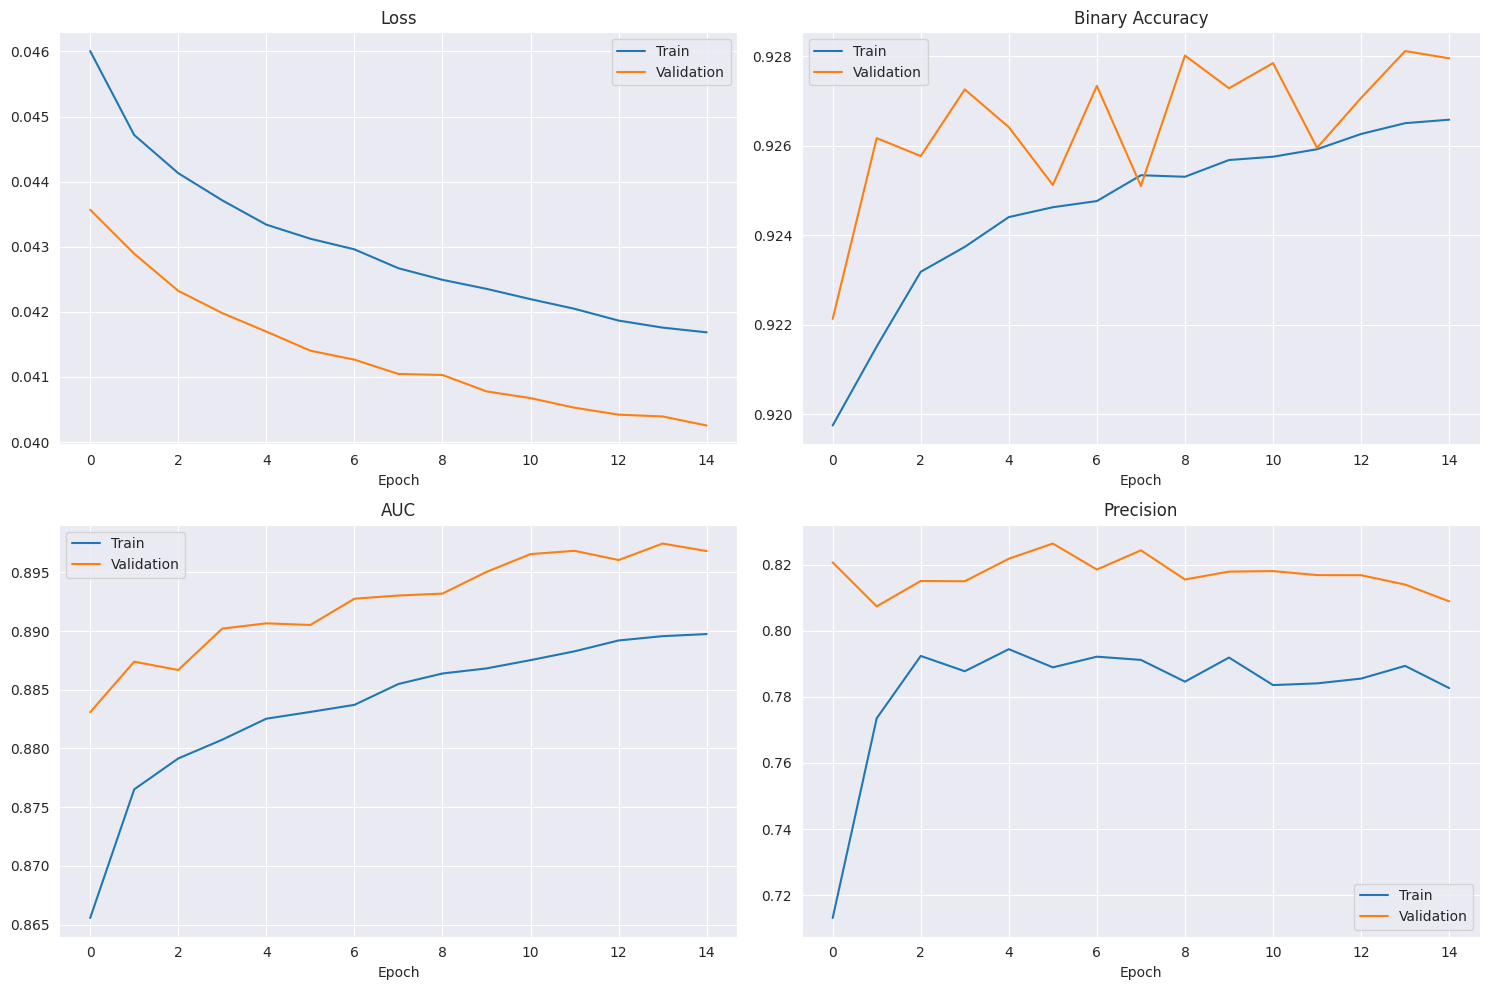

In [29]:
plot_training_history(history2)

In [30]:
test_gen = create_tf_dataset(test_df, labels, BATCH_SIZE, IMG_SIZE, augment=False, shuffle=False)
y_pred_proba, y_pred, y_true = evaluate_model(model, test_gen, labels)



=== ОЦЕНКА МОДЕЛИ ===
1600/1600 ━━━━━━━━━━━━━━━━━━━━ 68s 38ms/step

Метрики по классам:
------------------------------------------------------------
No Finding          : AUC=0.713, AP=0.649
Atelectasis         : AUC=0.693, AP=0.242
Cardiomegaly        : AUC=0.779, AP=0.172
Effusion            : AUC=0.770, AP=0.412
Infiltration        : AUC=0.692, AP=0.376
Mass                : AUC=0.649, AP=0.123
Nodule              : AUC=0.674, AP=0.126
Pneumonia           : AUC=0.669, AP=0.038
Pneumothorax        : AUC=0.837, AP=0.367
Consolidation       : AUC=0.698, AP=0.123
Edema               : AUC=0.806, AP=0.120
Emphysema           : AUC=0.836, AP=0.209
Fibrosis            : AUC=0.769, AP=0.057
Pleural_Thickening  : AUC=0.708, AP=0.088
Hernia              : AUC=0.857, AP=0.057

Общие метрики:
Macro AUC: 0.743
Macro AP:  0.211


## Сравнение с baseline моделью
### Выводы

1. Macro AUC почти одинаковый — минимальное улучшение
2. Macro AP значительно лучше (+21%) — EfficientNet лучше на редких классах

### Паттерн:

1. Baseline лучше на частых классах (Effusion, Edema, No Finding)
2. EfficientNet лучше на редких классах (Hernia +12%, Emphysema +8%)

Исходя из информации которую получилось изучить для ChestX-ray14 это типично — датасет с шумными метками, потолок около 0.82–0.84. Твои результаты на уровне публикаций.

## TODO
Необходимо изменить подход к задаче. Планирую разделить модель на 2: input -> Binary classification(есть болезь или нет) -> Label classifier(Если есть то какие)

In [31]:
model.save('advanced_v2.h5')